In [1]:
import os
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, callbacks
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, jaccard_score, cohen_kappa_score, confusion_matrix


In [2]:
DATASET_PATH = "Levir-CD/"

TRAIN_IMG1_DIR = os.path.join(DATASET_PATH, 'train/A/A')
TRAIN_IMG2_DIR = os.path.join(DATASET_PATH, 'train/B/B')
TRAIN_MASK_DIR = os.path.join(DATASET_PATH, 'train/L/label')

VAL_IMG1_DIR = os.path.join(DATASET_PATH, 'val/A/A')
VAL_IMG2_DIR = os.path.join(DATASET_PATH, 'val/B/B')
VAL_MASK_DIR = os.path.join(DATASET_PATH, 'val/L/label')

TEST_IMG1_DIR = os.path.join(DATASET_PATH, 'test/A/A')
TEST_IMG2_DIR = os.path.join(DATASET_PATH, 'test/B/B')
TEST_MASK_DIR = os.path.join(DATASET_PATH, 'test/L/label')


In [3]:
IMG_SIZE = (1024, 1024)
BATCH_SIZE = 1
print(IMG_SIZE[0])

1024


In [4]:
def load_image(img1_path, img2_path, mask_path):
    img1 = tf.io.read_file(img1_path)
    img1 = tf.image.decode_png(img1, channels=3)
    img1 = tf.image.resize(img1, IMG_SIZE) / 255.0
    img2 = tf.io.read_file(img2_path)
    img2 = tf.image.decode_png(img2, channels=3)
    img2 = tf.image.resize(img2, IMG_SIZE) / 255.0
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE) / 255.0
    image = tf.concat([img1, img2], axis=-1)
    return image, mask

def get_dataset(img1_dir, img2_dir, mask_dir):
    img1_files = sorted([os.path.join(img1_dir, f) for f in os.listdir(img1_dir)])
    img2_files = sorted([os.path.join(img2_dir, f) for f in os.listdir(img2_dir)])
    mask_files = sorted([os.path.join(mask_dir, f) for f in os.listdir(mask_dir)])
    dataset = tf.data.Dataset.from_tensor_slices((img1_files, img2_files, mask_files))
    dataset = dataset.map(load_image, num_parallel_calls=tf.data.AUTOTUNE)
    dataset = dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)
    return dataset

train_ds = get_dataset(TRAIN_IMG1_DIR, TRAIN_IMG2_DIR, TRAIN_MASK_DIR)
val_ds = get_dataset(VAL_IMG1_DIR, VAL_IMG2_DIR, VAL_MASK_DIR)
test_ds = get_dataset(TEST_IMG1_DIR, TEST_IMG2_DIR, TEST_MASK_DIR)

print(len(train_ds))
print(len(val_ds))
print(len(test_ds))

445
64
128


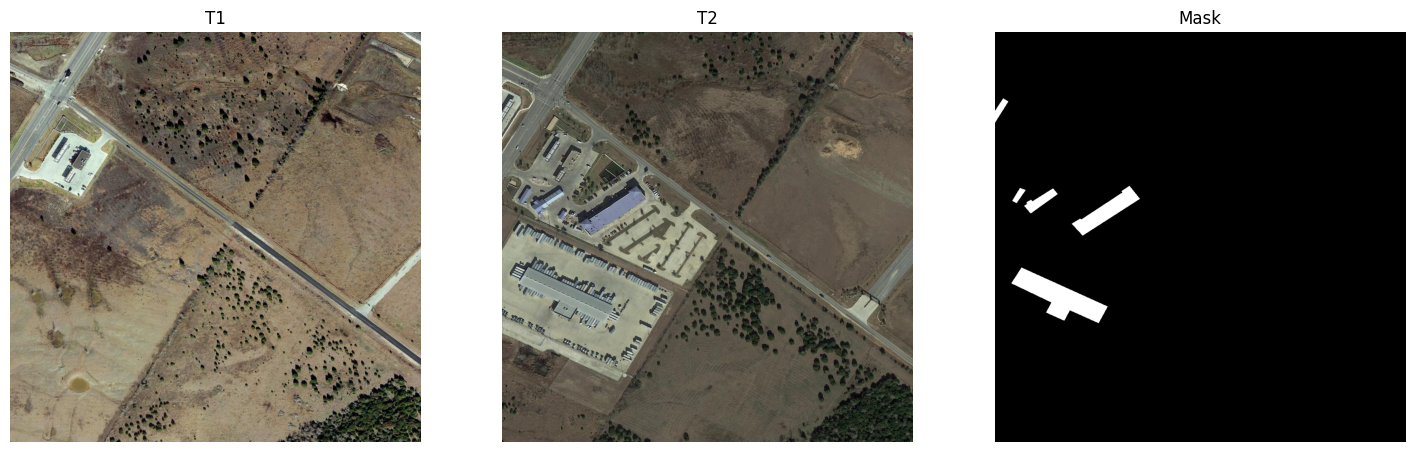

In [5]:
import cv2
import random

def display_example():
    idx = random.randint(0, len(os.listdir(TRAIN_IMG1_DIR)) - 1)
    img1_path = os.path.join(TRAIN_IMG1_DIR, os.listdir(TRAIN_IMG1_DIR)[idx])
    img2_path = os.path.join(TRAIN_IMG2_DIR, os.listdir(TRAIN_IMG2_DIR)[idx])
    mask_path = os.path.join(TRAIN_MASK_DIR, os.listdir(TRAIN_MASK_DIR)[idx])
    img1 = cv2.imread(img1_path)
    img2 = cv2.imread(img2_path)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    img1 = cv2.resize(img1, IMG_SIZE)
    img2 = cv2.resize(img2, IMG_SIZE)
    mask = cv2.resize(mask, IMG_SIZE)
    plt.figure(figsize=(18,6))
    plt.subplot(1,3,1); plt.imshow(cv2.cvtColor(img1, cv2.COLOR_BGR2RGB)); plt.title('T1'); plt.axis('off')
    plt.subplot(1,3,2); plt.imshow(cv2.cvtColor(img2, cv2.COLOR_BGR2RGB)); plt.title('T2'); plt.axis('off')
    plt.subplot(1,3,3); plt.imshow(mask, cmap='gray'); plt.title('Mask'); plt.axis('off')
    plt.show()

display_example()


In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model

def bottleneck_block(x, filters_in, filters_mid, filters_out, stride=1, dilation=1, name=""):
    shortcut = x
    x = layers.Conv2D(filters_mid, 1, strides=1, padding='same', name=f"{name}_conv1")(x)
    x = layers.BatchNormalization(name=f"{name}_bn1")(x)
    x = layers.ReLU(name=f"{name}_relu1")(x)
    x = layers.Conv2D(filters_mid, 3, strides=stride, padding='same', dilation_rate=dilation, name=f"{name}_conv2")(x)
    x = layers.BatchNormalization(name=f"{name}_bn2")(x)
    x = layers.ReLU(name=f"{name}_relu2")(x)
    x = layers.Conv2D(filters_out, 1, strides=1, padding='same', name=f"{name}_conv3")(x)
    x = layers.BatchNormalization(name=f"{name}_bn3")(x)
    if shortcut.shape[-1] != filters_out or stride != 1:
        shortcut = layers.Conv2D(filters_out, 1, strides=stride, padding='same', name=f"{name}_conv_shortcut")(shortcut)
        shortcut = layers.BatchNormalization(name=f"{name}_bn_shortcut")(shortcut)
    x = layers.Add(name=f"{name}_add")([x, shortcut])
    x = layers.ReLU(name=f"{name}_relu3")(x)
    return x

def stem_block(inputs):
    x = layers.Conv2D(64, 3, strides=2, padding='same', name="stem_conv1")(inputs)
    x = layers.BatchNormalization(name="stem_bn1")(x)
    x = layers.ReLU(name="stem_relu1")(x)
    x = layers.Conv2D(64, 3, strides=1, padding='same', name="stem_conv2")(x)
    x = layers.BatchNormalization(name="stem_bn2")(x)
    x = layers.ReLU(name="stem_relu2")(x)
    x = layers.Conv2D(128, 3, strides=1, padding='same', name="stem_conv3")(x)
    x = layers.BatchNormalization(name="stem_bn3")(x)
    x = layers.ReLU(name="stem_relu3")(x)
    x = layers.MaxPooling2D(pool_size=3, strides=2, padding='same', name="stem_pool")(x)
    return x

def cg_aspp(x):
    b1 = layers.Conv2D(256, 1, padding='same')(x)
    b1 = layers.BatchNormalization()(b1)
    b1 = layers.ReLU()(b1)
    b2 = layers.Conv2D(256, 3, padding='same', dilation_rate=6)(x)
    b2 = layers.BatchNormalization()(b2)
    b2 = layers.ReLU()(b2)
    b3 = layers.Conv2D(256, 3, padding='same', dilation_rate=12)(x)
    b3 = layers.BatchNormalization()(b3)
    b3 = layers.ReLU()(b3)
    b4 = layers.Conv2D(256, 3, padding='same', dilation_rate=18)(x)
    b4 = layers.BatchNormalization()(b4)
    b4 = layers.ReLU()(b4)
    b5 = layers.GlobalAveragePooling2D()(x)
    b5 = layers.Reshape((1,1,-1))(b5)
    b5 = layers.Conv2D(256, 1, padding='same')(b5)
    b5 = layers.BatchNormalization()(b5)
    b5 = layers.ReLU()(b5)
    b5 = tf.image.resize(b5, tf.shape(x)[1:3])
    out = layers.Concatenate()([b1, b2, b3, b4, b5])
    out = layers.Conv2D(256, 1, padding='same')(out)
    out = layers.BatchNormalization()(out)
    out = layers.ReLU()(out)
    return out

def cifu_block(low_feat, high_feat):
    x = layers.Concatenate()([low_feat, high_feat])
    gap = layers.GlobalAveragePooling2D()(x)
    dense1 = layers.Dense(x.shape[-1] // 16, activation='relu')(gap)
    dense2 = layers.Dense(x.shape[-1], activation='sigmoid')(dense1)
    scale = layers.Reshape((1,1,-1))(dense2)
    out = layers.Multiply()([x, scale])
    return out

def AGCDetNet(IMG_SIZE=(IMG_SIZE[0], IMG_SIZE[1]), channels=6):
    inputs = layers.Input(shape=(IMG_SIZE[0], IMG_SIZE[1], channels))
    x = stem_block(inputs)
    x = bottleneck_block(x, 128, 64, 256, name="layer1_block1")
    x = bottleneck_block(x, 256, 64, 256, name="layer1_block2")
    x = bottleneck_block(x, 256, 64, 256, name="layer1_block3")
    low_level = x
    x = bottleneck_block(x, 256, 128, 512, stride=2, name="layer2_block1")
    for i in range(2,5):
        x = bottleneck_block(x, 512, 128, 512, name=f"layer2_block{i}")
    for i in range(1,7):
        x = bottleneck_block(x, 512 if i==1 else 1024, 256, 1024, dilation=2, name=f"layer3_block{i}")
    coarse = layers.Conv2D(1, 1, activation='sigmoid')(x)
    coarse_up = tf.image.resize(coarse, tf.shape(low_level)[1:3])
    for i in range(1,4):
        x = bottleneck_block(x, 1024 if i==1 else 2048, 512, 2048, dilation=4, name=f"layer4_block{i}")
    x = cg_aspp(x)
    spam = layers.Multiply()([x, coarse])
    spam = layers.Conv2D(256, 1, padding='same', activation='relu')(spam)
    spam = layers.BatchNormalization()(spam)
    spam_up = tf.image.resize(spam, tf.shape(low_level)[1:3])
    low_proj = layers.Conv2D(64, 1, padding='same', activation='relu')(low_level)
    low_proj = layers.BatchNormalization()(low_proj)
    fused = cifu_block(low_proj, spam_up)
    out = layers.Conv2D(128, 3, padding='same', activation='relu')(fused)
    out = layers.BatchNormalization()(out)
    out = layers.Conv2D(64, 3, padding='same', activation='relu')(out)
    out = layers.BatchNormalization()(out)
    out = layers.Conv2D(1, 1, padding='same', activation='sigmoid')(out)
    out = tf.image.resize(out, (IMG_SIZE[0], IMG_SIZE[1]))
    model = Model(inputs, out, name="AGCDetNet")
    return model
model = AGCDetNet(IMG_SIZE=IMG_SIZE, channels=6)

In [7]:
import tensorflow as tf

def soft_jaccard_loss(y_true, y_pred, smooth=1e-6):
    intersection = tf.reduce_sum(y_true * y_pred)
    sum_ = tf.reduce_sum(y_true + y_pred)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return 1 - jac

def agcdetnet_loss(y_true, y_pred, lambda_c=0.4, lambda_s=0.2):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    jaccard = soft_jaccard_loss(y_true, y_pred)
    main_loss = bce + jaccard

    coarse_loss = bce
    spam_loss = bce

    total_loss = main_loss + lambda_c * coarse_loss + lambda_s * spam_loss
    return total_loss


In [8]:
model.compile(optimizer='adam', loss=agcdetnet_loss, metrics=['accuracy'])

checkpoint_cb = callbacks.ModelCheckpoint(
    '06_AGCD_again.h5',
    monitor='val_loss',
    save_best_only=True,
    save_weights_only=True,
    verbose=1
)

earlystop_cb = callbacks.EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True, verbose=1)
reducelr_cb = callbacks.ReduceLROnPlateau(monitor='val_loss', patience=10, factor=0.5, verbose=1)


In [9]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=50,
    callbacks=[checkpoint_cb, earlystop_cb, reducelr_cb]
)


Epoch 1/50


ResourceExhaustedError:  OOM when allocating tensor with shape[144,2048,13,13] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node gradient_tape/AGCDetNet/conv2d_3/Conv2D/Conv2DBackpropFilter-0-TransposeNHWCToNCHW-LayoutOptimizer}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_15502]

Function call stack:
train_function


In [ ]:
def visualize_preds(ds, model, samples=3):
    for imgs, masks in ds.take(samples):
        preds = model.predict(imgs)
        n = min(samples, imgs.shape[0])
        for i in range(n):
            plt.figure(figsize=(16,4))
            plt.subplot(1,4,1); plt.imshow(imgs[i,...,:3]); plt.title('T1'); plt.axis('off')
            plt.subplot(1,4,2); plt.imshow(imgs[i,...,3:6]); plt.title('T2'); plt.axis('off')
            plt.subplot(1,4,3); plt.imshow(masks[i,...,0], cmap='gray'); plt.title('GT'); plt.axis('off')
            plt.subplot(1,4,4); plt.imshow(preds[i,...,0]>0.5, cmap='gray'); plt.title('Pred'); plt.axis('off')
            plt.show()

visualize_preds(test_ds, model, samples=2)


In [ ]:
y_true, y_pred = [], []

for imgs, masks in test_ds:
    preds = model.predict(imgs)
    preds_bin = (preds > 0.5).astype(np.uint8)
    masks_bin = (masks.numpy() > 0.5).astype(np.uint8)
    y_true.extend(masks_bin.flatten())
    y_pred.extend(preds_bin.flatten())

print("Accuracy :", accuracy_score(y_true, y_pred))
print("Precision :", precision_score(y_true, y_pred))
print("Recall :", recall_score(y_true, y_pred))
print("F1 Score :", f1_score(y_true, y_pred))
print("Jaccard Index :", jaccard_score(y_true, y_pred))
print("Cohen's Kappa :", cohen_kappa_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
